## Load and normalize MNIST dataset

In [6]:
%matplotlib inline

from __future__ import print_function

import torch
import torchvision
import torchvision.transforms as transforms
from torchviz import make_dot, make_dot_from_trace

# Hyper-parameters
epochs = 12
batch_size = 8
lr = 0.01
momentum = 0.75

# Parameters
cuda = True  # default to False --> training and testing on CPU
log_step_percentage = 10

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
mnist_mean = 0.1307
mnist_std = 0.3081

# Initialize training set and testing set of MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mnist_mean,), (mnist_std,))
])

trainset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST('data', train=False, transform=transform)

# Initialize dataloaders for training and testing
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


## Show some random training and testing images in MNIST

Training random samples:
    4     9     2     0     7     4     9     1

Testing random samples:
    7     2     1     0     4     1     4     9

<class 'torch.Tensor'>
torch.Size([8, 1, 28, 28])


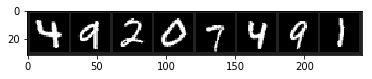

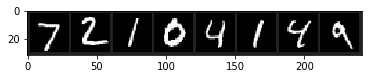

In [7]:
import matplotlib.pyplot as plt
import numpy as np


# Function to show an image
def imshow(img):
    img = img * mnist_std +  mnist_mean # unnormalize
    npimg = img.numpy()
    plt.figure()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# Get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))  # show images
print('Training random samples:')
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))  # print labels
print()

# Get some random testing images
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))  # show images
print('Testing random samples:')
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))  # print labels
print()

print(type(images))
print(images.shape)

## Define a Convolutional Neural Network - baseline

In [8]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class BaselineConvNet(nn.Module):
    def __init__(self):
        super(BaselineConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc1 = nn.Linear(108, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 4))
        x = x.view(-1, 108)
        x = self.fc1(x)
        return F.log_softmax(x)


baseline_conv_net = BaselineConvNet()

# Move the model to GPU if cuda set to True
if cuda:
    baseline_conv_net.cuda()
    

## Define a Convolutional Neural Network - advance
### - You should complete this part!!!

AdvanceConvNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 24, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout2d(p=0.5)
  (fc1): Linear(in_features=600, out_features=320, bias=True)
  (fc2): Linear(in_features=320, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=40, bias=True)
  (fc4): Linear(in_features=40, out_features=10, bias=True)
)


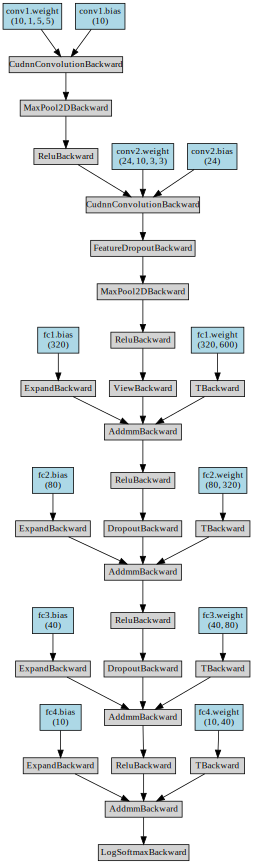

In [9]:
class AdvanceConvNet(nn.Module):
    """
    Please implement this part by yourself
    """
    def __init__(self):
        super(AdvanceConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 24, kernel_size=3)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(600, 320)
        self.fc2 = nn.Linear(320, 80)
        self.fc3 = nn.Linear(80, 40)
        self.fc4 = nn.Linear(40, 10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # 28x28x10 -> 24x24x10 -> 12x12x10
        x = F.relu(F.max_pool2d(self.dropout(self.conv2(x)), 2)) # 12x12x24 -> 10x10x24 -> 5x5x24
        x = x.view(-1, 600) # flatten
        
        x = F.relu(self.fc1(x)) # 600 -> 320
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x)) # 320 -> 80
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc3(x)) # 80 -> 40
        x = self.fc4(x) # 40 -> 10
        return F.log_softmax(x , dim=1)
        


advance_conv_net = AdvanceConvNet()

# Move the model to GPU if cuda set to True
if cuda:
    advance_conv_net.cuda()
print(advance_conv_net)

x = Variable(torch.randn(1,1,28,28).cuda())
y = advance_conv_net(x)
make_dot(y, params=dict(advance_conv_net.named_parameters()))


## Define a loss function and optimizer

In [10]:
import torch.optim as optim


#model = baseline_conv_net  # set the model to baseline_conv_net or the advanced one you implement
model = advance_conv_net

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)


## Train and test the network
### - You should complete this part!!!

In [14]:
log_interval = len(train_loader) / log_step_percentage

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()

        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        
        """
        output = model(????)  # please fill in what you should pass into the model to derive the output
        loss = F.nll_loss(????, ????)  # please fill in what you should pass into the loss function to compute loss
        """
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch,
                                                                           batch_idx * len(data),
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss.item()))

def test():
    model.eval()
    test_loss = 0.
    correct = 0.
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
            
        data, target = Variable(data, volatile=True), Variable(target)
        
        """
        output = model(????)  # please fill in what you should pass into the model to derive the output
        loss = F.nll_loss(????, ????, size_average=False)  # please fill in what you should pass into the loss function
                                                           # to compute loss
        test_loss += loss.data[0]  # sum up batch loss
        """
        output = model(data)
        loss = F.nll_loss(output, target, size_average=False)
        test_loss += loss.item()
        
        
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss,
                                                                                 correct,
                                                                                 len(test_loader.dataset),
                                                                                 100. * correct / len(test_loader.dataset)))


for epoch in range(1, epochs + 1):
    train(epoch)
    test()
    

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.000667
Train Epoch: 1 [6000/60000 (10%)]	Loss: 0.516970
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.160854
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.076961
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.076481
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.041089
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.313567
Train Epoch: 1 [42000/60000 (70%)]	Loss: 0.217050
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.024446
Train Epoch: 1 [54000/60000 (90%)]	Loss: 0.021428


D:\Conda\envs\py36\lib\site-packages\ipykernel_launcher.py:37: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Test set: Average loss: 0.0788, Accuracy: 9810/10000 (98.00%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.008594
Train Epoch: 2 [6000/60000 (10%)]	Loss: 0.390572
Train Epoch: 2 [12000/60000 (20%)]	Loss: 0.647606
Train Epoch: 2 [18000/60000 (30%)]	Loss: 0.011450
Train Epoch: 2 [24000/60000 (40%)]	Loss: 0.431580
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.717506
Train Epoch: 2 [36000/60000 (60%)]	Loss: 0.254286
Train Epoch: 2 [42000/60000 (70%)]	Loss: 0.108724
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.409387
Train Epoch: 2 [54000/60000 (90%)]	Loss: 0.044309

Test set: Average loss: 0.0682, Accuracy: 9821/10000 (98.00%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.367150
Train Epoch: 3 [6000/60000 (10%)]	Loss: 0.115825
Train Epoch: 3 [12000/60000 (20%)]	Loss: 0.440643
Train Epoch: 3 [18000/60000 (30%)]	Loss: 0.555089
Train Epoch: 3 [24000/60000 (40%)]	Loss: 0.020908
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.895536
Train Epoch: 3 [36000/60000 (60%)]	Loss: 0.581632
Train Epoch: 3 [42000/60000 (70%)]

## Test the network on custom test data
### - You should complete this part!!!

data1.png - prediction --> tensor(2, device='cuda:0')
data2.png - prediction --> tensor(8, device='cuda:0')
data3.png - prediction --> tensor(4, device='cuda:0')
data4.png - prediction --> tensor(8, device='cuda:0')
data5.png In correct: predict: 7 , real: 9
data6.png - prediction --> tensor(9, device='cuda:0')
data7.png - prediction --> tensor(5, device='cuda:0')
data8.png - prediction --> tensor(3, device='cuda:0')
data9.png - prediction --> tensor(0, device='cuda:0')
Accuracy rate: 88.89%


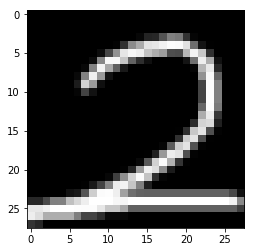

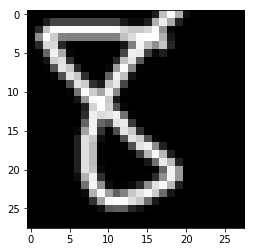

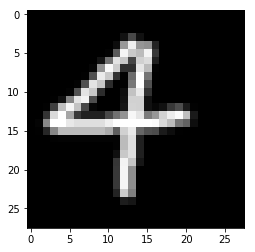

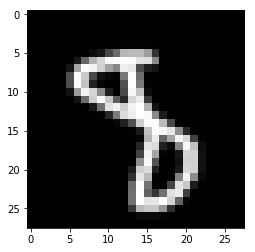

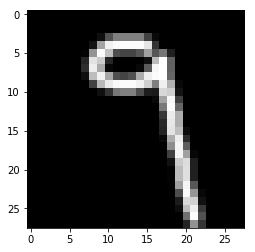

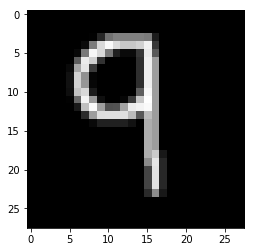

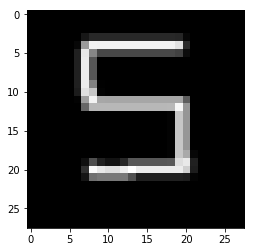

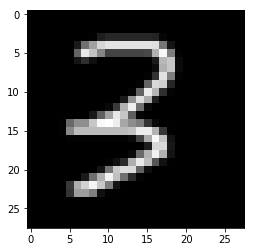

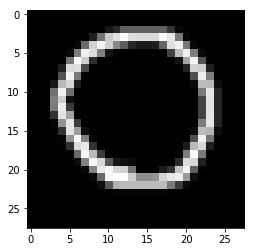

In [15]:
from os import listdir
from os.path import isfile, join
from PIL import Image

custom_test_root = 'data/custom_test'  # the directory where custom test handwritten digit images are stored

labels = [2,8,4,8,9,9,5,3,0]
totalImg = 9;
corrects = 0
files = sorted([f for f in listdir(custom_test_root) if isfile(join(custom_test_root, f))])
for i, img_name in enumerate(files, 1):
    full_img_path = join(custom_test_root, img_name)
    
    with Image.open(full_img_path).convert('L') as img:
        img = img.resize((28, 28), Image.BILINEAR)

        img_tensor = transform(img)  # use the defined composed transform functions to transform our custom test image
        if cuda:
            img_tensor = img_tensor.cuda()
        img_tensor.unsqueeze_(0)  # Add batch dimension to the image data

        """
        Implement this part on your own~
        """
        output = model(img_tensor)
        pred = output.data.max(1, keepdim=True)[1][0][0]  # get the index of the max log-probability

        plt.figure()
        plt.imshow(np.asarray(img), cmap='gray')
        
        if labels[i-1] == pred:           
            corrects = corrects + 1
            print(img_name, '- prediction -->', pred)
        else:
            print('%s In correct: predict: %d , real: %d' % (img_name, int(pred),int(labels[i-1])))

print('Accuracy rate: {:.2f}%'.format( (corrects/totalImg)*100))

In [16]:
correct = 0
total = 0
for data in test_loader:
    images, labels = data
    if cuda:
        images = images.cuda()
        labels = labels.cuda()
    outputs = model(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %


In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for data in test_loader:
    
    images, labels = data
    if cuda:
        images = images.cuda()
        labels = labels.cuda()
        
    outputs = model(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    
    for i in range(8):
        label = labels[i]
        class_correct[label] += int(c[i])
        class_total[label] += 1
   
    


for i in range(10):
    print('Accuracy of %5s : %2d %% (%d/%d)' % (
        classes[i], 100 * int(class_correct[i]) / int(class_total[i]), int(class_correct[i]),int(class_total[i])))


Accuracy of     0 : 99 % (978/980)
Accuracy of     1 : 99 % (1133/1135)
Accuracy of     2 : 98 % (1020/1032)
Accuracy of     3 : 98 % (996/1010)
Accuracy of     4 : 98 % (968/982)
Accuracy of     5 : 98 % (880/892)
Accuracy of     6 : 97 % (938/958)
Accuracy of     7 : 98 % (1015/1028)
Accuracy of     8 : 98 % (963/974)
Accuracy of     9 : 97 % (982/1009)
